In [1]:
import glob
import os
import re 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

txt_file_path = './data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2  
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    if len(sentence.split()) > 15 : #token 개수 제한
        sentence = ""
        
    return sentence

In [3]:
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue #공백 무시
    if sentence[-1] == ":": continue # : 무시
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence) == 0: continue #token 개수 제한
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
print("정제된 문장 수 : ",len(corpus))
corpus[:10]

정제된 문장 수 :  156013


['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [4]:
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2967 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  118 ...    0    0    0]
 [   2  258  194 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f12a85a26d0>


In [5]:
src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:] 

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6263    3    0    0    0]
[  50    4   95  303   62   53    9  946 6263    3    0    0    0    0]


In [6]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 42)

In [7]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


In [8]:
def tensor_to_dataset(src_input,tgt_input):
    
    BUFFER_SIZE = len(src_input)
    BATCH_SIZE = 256
    steps_per_epoch = len(src_input) // BATCH_SIZE

     # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
    VOCAB_SIZE = tokenizer.num_words + 1   

    dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset = tensor_to_dataset(enc_train, dec_train)
valid_dataset = tensor_to_dataset(enc_val, dec_val)

In [9]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size): #생성자 :  Layer 정의
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) 
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x): #호출 함수
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [10]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
hist = model.fit(train_dataset,epochs=10,validation_data=valid_dataset)

Epoch 1/10
487/487 [==============================] - 265s 503ms/step - loss: 3.4159 - val_loss: 3.0332
Epoch 2/10
487/487 [==============================] - 246s 504ms/step - loss: 2.8841 - val_loss: 2.8066
Epoch 3/10
487/487 [==============================] - 246s 504ms/step - loss: 2.6391 - val_loss: 2.6459
Epoch 4/10
487/487 [==============================] - 246s 504ms/step - loss: 2.4028 - val_loss: 2.5132
Epoch 5/10
487/487 [==============================] - 246s 505ms/step - loss: 2.1689 - val_loss: 2.4067
Epoch 6/10
487/487 [==============================] - 246s 505ms/step - loss: 1.9443 - val_loss: 2.3288
Epoch 7/10
487/487 [==============================] - 245s 503ms/step - loss: 1.7350 - val_loss: 2.2615
Epoch 8/10
487/487 [==============================] - 247s 506ms/step - loss: 1.5445 - val_loss: 2.2182
Epoch 9/10
487/487 [==============================] - 247s 506ms/step - loss: 1.3808 - val_loss: 2.1958
Epoch 10/10
487/487 [==============================] - 247s 507m

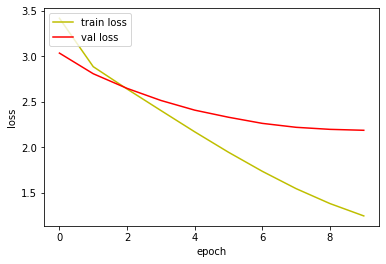

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


loss_ax.plot(hist.history['loss'],'y',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r',label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
plt.show()

In [12]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다.
    while True:
        predict = model(test_tensor) # 입력받은 문장의 텐서를 입력합니다.
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다.
        
        # 우리 모델이 새롭계 예측한 단어를 입력 문장의 뒤에 붙여줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        
        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면 while 루프를 돌면서 다음 단어를 예측해야합니다.
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len:
            break
    
    generated = ""
    
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다.
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    
    return generated # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [13]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna crack <end> '